In [1]:
import os
import tensorflow as tf
from model import Model
from input_pipe import InputPipe
from feeder import VarFeeder
from tqdm import trange
import matplotlib.pyplot as plt
import collections
import pandas as pd
import numpy as np
from trainer import predict
from hparams import build_hparams
import hparams
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def smape(true, pred):
    summ = np.abs(true) + np.abs(pred)
    smape = np.where(summ == 0, 0, np.abs(true - pred) / summ)
    return smape

def mae(true, pred):
    return np.abs(np.abs(true) - np.abs(pred))

def mean_smape(true, pred):
    raw_smape = smape(true, pred)
    masked_smape = np.ma.array(raw_smape, mask=np.isnan(raw_smape))
    return masked_smape.mean()

def mean_mae(true, pred):
    raw_mae = mae(true, pred)
    masked_mae = np.ma.array(raw_mae, mask=np.isnan(raw_mae))
    return masked_mae.mean()

def show_single(vm, scope=288, bad_case=True):
    name = preds.index[vm]
    if bad_case:
        bad_path = os.path.join('data/badcase', 'single_rnn_mae_beyond_1000_vm_uuids')
        bad_list = []
        with open(bad_path, 'r') as f:
            line = f.readline()
            while(line):
                line = line[:-1] + ".hdf5"
                if line in preds.index:
                    bad_list.append(line)
                line = f.readline()
        name = bad_list[vm]
    
    # mean mae for each row
    print(f'vm name: {name}')
    prev.loc[name, ends[vm] - scope : ends[vm]].plot(logy=True)
    (preds.loc[name, :]).plot(logy=True)
    # mean loss
    print(mean_mae(prev.loc[name, ends[vm] - 288 : ends[vm]], preds.loc[name, :]))

In [3]:
from make_features import read_all, read_pickle, find_start_end
df_all = read_all()
starts, ends = find_start_end(df_all.values)

/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/site-packages/tables/leaf.py:414: PerformanceWarning: The Leaf ``/df/block0_values`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/lihaocheng_i/.conda/envs/py3/lib/python3.6/site-packages/pandas/io/pytables.py:734: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help auto

In [4]:
prev = df_all.apply(lambda x : np.exp(x) - 1)

In [5]:
paths = [p for p in tf.train.get_checkpoint_state('data/cpt/s32').all_model_checkpoint_paths]

In [6]:
paths

['data/cpt/s32/cpt-126']

In [7]:
#tf.reset_default_graph()
#preds = predict(paths, default_hparams(), back_offset=0,
#                    n_models=3, target_model=0, seed=2, batch_size=2048, asgd=True)
t_preds = []
for tm in range(3):
    tf.reset_default_graph()
    t_preds.append(predict(paths, build_hparams(hparams.params_s32), back_offset=0, predict_window=288,
                    n_models=3, target_model=tm, seed=2, batch_size=1024, asgd=True))
preds=sum(t_preds) /3

INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-126
0...🎉
INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-126
0...🎉
INFO:tensorflow:Restoring parameters from data/vars/feeder.cpt
INFO:tensorflow:Restoring parameters from data/cpt/s32/cpt-126
0...🎉


In [8]:
# mean mae
preds.index = [idx.decode('ascii') for idx in preds.index]
res = 0
for idx in preds.index:
    res += np.abs(preds.loc[idx, :] - prev.loc[idx, -288:]).sum()
res / (len(preds.index) * 288) 

422.77079341827994

Visual sanity check

vm name: 2b8a5864954553fabe65feb160e089ab.hdf5
1500.4276784261074


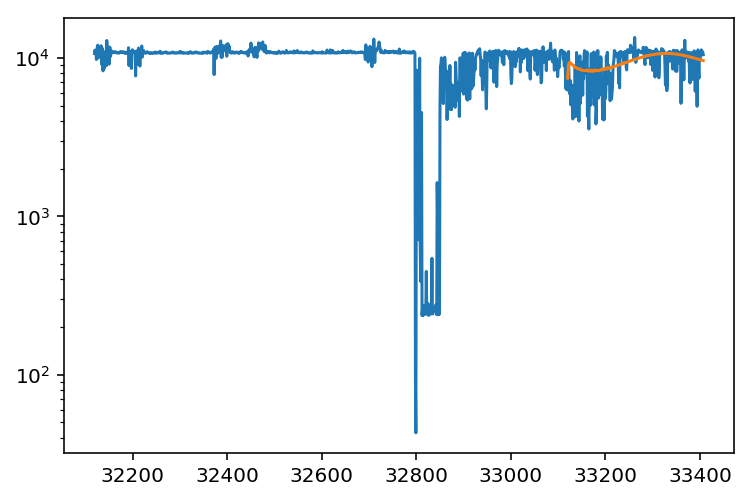

In [19]:
show_single(110, 1288)

In [12]:
missing_vm = prev.index.difference(preds.index)
# Use zeros for missing pages
rmdf = pd.DataFrame(index=missing_vm,
                    data=np.tile(0, (len(preds.columns),len(missing_vm))).T, columns=preds.columns)
f_preds = preds.append(rmdf).sort_index()

# Use zero for negative predictions
f_preds[f_preds < 0.5] = 0
# Rouns predictions to nearest int
f_preds = np.round(f_preds).astype(np.int64)